In [4]:
import pymrio as pym
import numpy as np
import pandas as pd
import pickle as pkl
import pathlib
import country_converter as coco
import json

def display_f(df):
    with pd.option_context('display.max_colwidth', None), pd.option_context('display.max_rows', None), pd.option_context('display.max_columns', None):
        display(df)
        
def lexico_reindex(mrio: pym.IOSystem) -> pym.IOSystem:
    """Reindex IOSystem lexicographicaly

    Sort indexes and columns of the dataframe of a :ref:`pymrio.IOSystem` by
    lexical order.

    Parameters
    ----------
    mrio : pym.IOSystem
        The IOSystem to sort

    Returns
    -------
    pym.IOSystem
        The sorted IOSystem

    """

    mrio.Z = mrio.Z.reindex(sorted(mrio.Z.index), axis=0)
    mrio.Z = mrio.Z.reindex(sorted(mrio.Z.columns), axis=1)
    mrio.Y = mrio.Y.reindex(sorted(mrio.Y.index), axis=0)
    mrio.Y = mrio.Y.reindex(sorted(mrio.Y.columns), axis=1)
    mrio.x = mrio.x.reindex(sorted(mrio.x.index), axis=0) #type: ignore
    mrio.A = mrio.A.reindex(sorted(mrio.A.index), axis=0)
    mrio.A = mrio.A.reindex(sorted(mrio.A.columns), axis=1)

    return mrio

exio_path = "../../../Data/Snakeruns/inputs/IOT_2019_ixi.zip"
exio3 = pym.parse_exiobase3(path=exio_path)
del exio3.IOT_2019_ixi

original_regions = exio3.get_regions()

cc = coco.CountryConverter()

dico = {region : cc.convert(region, src="EXIO3",to='continent') for region in original_regions}
#dico['WA'] = 'RoW'
#dico['WL'] = 'RoW'
#dico['WE'] = 'RoW'
#dico['WF'] = 'RoW'
#dico['WM'] = 'RoW'
#dico['DK'] = 'Germany'

#reg_agg_coco = coco.agg_conc(original_countries=original_regions, aggregates=dico)
reg_agg_coco = coco.agg_conc(original_countries=original_regions, aggregates={'DE':"Germany"},
 missing_countries='RoW')

exio3.aggregate(region_agg=reg_agg_coco)

attr = ['Z', 'Y', 'x', 'A', 'L', 'unit', 'population', 'meta', '__non_agg_attributes__', '__coefficients__', '__basic__']
tmp = list(exio3.__dict__.keys())
for at in tmp:
    if at not in attr:
        delattr(exio3,at)

old_sectors = exio3.get_sectors()

sec_agg_matrix = pd.read_excel("../other/133_7_sector_aggregation_exiobase3.ods", sheet_name="input", engine="odf", header=None, names=old_sectors)

exio3.aggregate(sector_agg=sec_agg_matrix.to_numpy())
with pathlib.Path("../other/sector_renaming_7.json").open('r') as f:
    a = json.load(f)
exio3.rename_sectors(a)
new_sectors = exio3.get_sectors()
sec_agg_matrix.index = new_sectors

sector_mapping = {k : [kk for kk in v.keys() if v[kk] == 1] for k,v in sec_agg_matrix.T.to_dict().items()}

In [ ]:
sector_mapping

In [9]:
with pathlib.Path("../../../Data/BoARIO-testing/163_mrio_params.json").open('r') as f:
    old_mrio_params = json.load(f)

new_mrio_params = old_mrio_params.copy()
new_mrio_params['capital_ratio_dict'] = {k:0 for k in sector_mapping.keys()}

for k in new_mrio_params['capital_ratio_dict'].keys():
    values = [old_mrio_params['capital_ratio_dict'][k_old] for k_old in sector_mapping[k]]
    new_mrio_params['capital_ratio_dict'][k] = np.mean(values).round(3)
    
new_mrio_params['inventories_dict'] = {k:0 for k in sector_mapping.keys()}

for k in new_mrio_params['inventories_dict'].keys():
    values = [np.inf if old_mrio_params['inventories_dict'][k_old] == "inf" else old_mrio_params['inventories_dict'][k_old] for k_old in sector_mapping[k]]
    new_mrio_params['inventories_dict'][k] = np.mean(values).round(3)
    
new_mrio_params['inventories_dict']

{'Agriculture & other': 9.0,
 'Extraction': 9.0,
 'Manufacture': 9.0,
 'Energy and utilities': 9.0,
 'Construction': 9.0,
 'Sales, Transports and Services': inf,
 'Others': inf}

In [10]:
exio3.get_sectors()

Index(['Agriculture & other', 'Extraction', 'Manufacture',
       'Energy and utilities', 'Construction',
       'Sales, Transports and Services', 'Others'],
      dtype='object', name='sector')

In [11]:
name = "7_sectors_DE_RoW"
with pathlib.Path("../../../Data/BoARIO-testing/"+name+"_mrio_params.json").open('w') as f:
    json.dump(new_mrio_params, f, indent=4)


In [5]:
name = "7_sectors_DE_RoW"

exio3.calc_all()
exio3 = lexico_reindex(exio3)
with open("../../../Data/BoARIO-testing/"+name+".pkl", 'wb') as f:
    pkl.dump(exio3, f)

In [6]:
exio3.Z

region                                             Germany                \
sector                                 Agriculture & other  Construction   
region  sector                                                             
Germany Agriculture & other                    2512.076040    186.552153   
        Construction                           1052.950543  27919.937435   
        Energy and utilities                   2782.913723   3741.866916   
        Extraction                              112.778699   2944.657011   
        Manufacture                            6810.698732  77216.861204   
        Others                                   99.248881    187.954803   
        Sales, Transports and Services        14484.410328  54537.867084   
RoW     Agriculture & other                    1640.773821     57.709774   
        Construction                             21.952657   1751.210759   
        Energy and utilities                     27.320405     96.684666   
        Extraction                               59.827753    191.321344   
        Manufacture                            3269.647074  35597.376138   
        Others                                    3.910700     34.685455   
        Sales, Transports and Services          627.920779   6922.129152   

region                                                                    \
sector                                 Energy and utilities   Extraction   
region  sector                                                             
Germany Agriculture & other                       39.674371    61.554486   
        Construction                            7957.364483   326.346750   
        Energy and utilities                   49239.113025  1006.732355   
        Extraction                              4468.758130  1076.982983   
        Manufacture                            13784.481606  2166.756226   
        Others                                   817.395115    83.904539   
        Sales, Transports and Services         52571.239328  4303.269075   
RoW     Agriculture & other                       16.091243    25.934146   
        Construction                             188.300216    36.435470   
        Energy and utilities                      86.722595    18.732354   
        Extraction                              1688.458136   155.473694   
        Manufacture                             5074.456312  1842.588024   
        Others                                    34.541080     5.421824   
        Sales, Transports and Services          4702.127030   754.965928   

region                                                               \
sector                                    Manufacture        Others   
region  sector                                                        
Germany Agriculture & other              33046.136730     85.567394   
        Construction                      6936.793738   2248.297097   
        Energy and utilities             53256.333164   3237.601611   
        Extraction                        5483.105485    163.400271   
        Manufacture                     460598.305776  10880.111549   
        Others                            2361.011220  21956.748958   
        Sales, Transports and Services  352407.265927  37431.820241   
RoW     Agriculture & other               9076.780812     54.367455   
        Construction                      1171.346147     35.347696   
        Energy and utilities               873.040637     16.954403   
        Extraction                       23407.437620     15.909680   
        Manufacture                     296867.617272   3295.366638   
        Others                             274.764894   1555.088206   
        Sales, Transports and Services   49000.202287   4765.739100   

region                                                                 \
sector                                 Sales, Transports and Services   
region  sector                                              

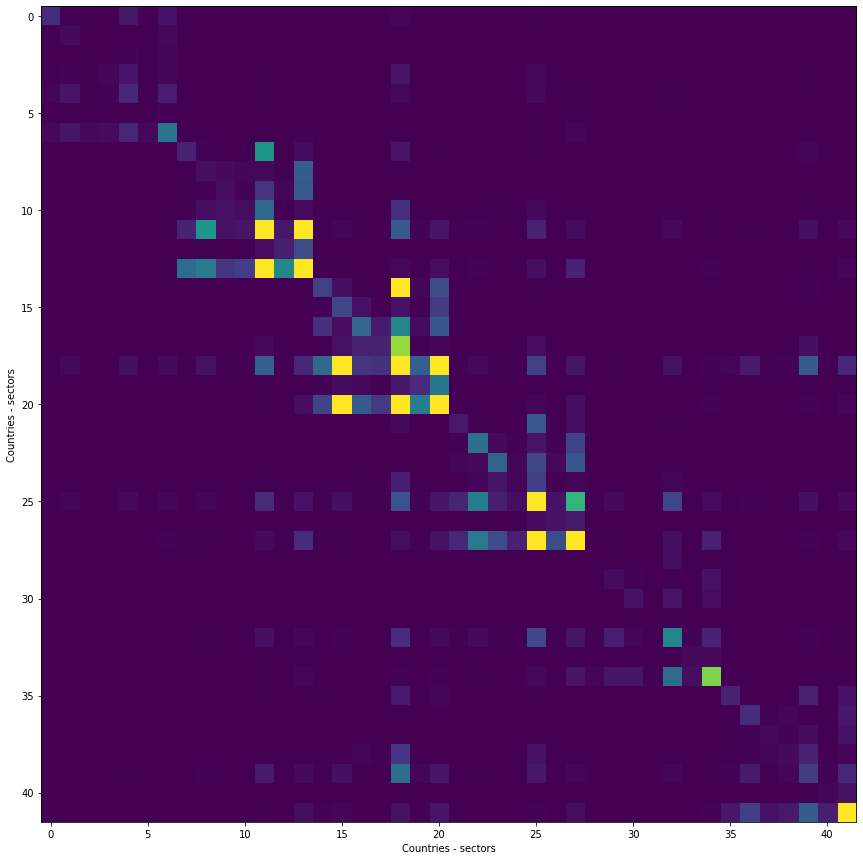

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(exio3.Z, vmax=1E6)
plt.xlabel('Countries - sectors')
plt.ylabel('Countries - sectors')
plt.show()

In [2]:
import pickle as pkl
with open("../../../Data/BoARIO-testing/minimal_mrio_DK.pkl", 'rb') as f:
    exio3 = pkl.load(f)
    
exio3.get_regions()

Index(['Africa', 'America', 'Asia', 'Denmark', 'Europe', 'Oceania'], dtype='object', name='region')

In [3]:
exio3.Y

region                                                 Africa  \
category                               Changes in inventories   
region  sector                                                  
Africa  Agriculture & other                        135.192970   
        Construction                                 8.357399   
        Energy and utilities                        24.992254   
        Extraction                                 649.368019   
        Manufacture                               3080.342717   
        Others                                      15.122069   
        Sales, Transports and Services           16609.671558   
America Agriculture & other                          1.484615   
        Construction                                 0.033263   
        Energy and utilities                         0.298234   
        Extraction                                  25.948263   
        Manufacture                                 80.560759   
        Others                                       0.022430   
        Sales, Transports and Services              17.867133   
Asia    Agriculture & other                          0.262983   
        Construction                                 0.176965   
        Energy and utilities                         3.599896   
        Extraction                                  11.135898   
        Manufacture                                219.900581   
        Others                                       0.026513   
        Sales, Transports and Services               3.470714   
Denmark Agriculture & other                          0.001494   
        Construction                                 0.127477   
        Energy and utilities                         0.000000   
        Extraction                                   0.000154   
        Manufacture                                  0.984867   
        Others                                       0.000102   
        Sales, Transports and Services               1.849596   
Europe  Agriculture & other                         11.790374   
        Construction                                 0.394183   
        Energy and utilities                         0.201105   
        Extraction                                 199.122767   
        Manufacture                                202.298459   
        Others                                       0.079819   
        Sales, Transports and Services             100.469733   
Oceania Agriculture & other                          0.333882   
        Construction                                 0.112713   
        Energy and utilities                         1.161817   
        Extraction                                  21.132082   
        Manufacture                                 77.153493   
        Others                                       0.057440   
        Sales, Transports and Services               6.471721   

region                                                       \
category                               Changes in valuables   
region  sector                                                
Africa  Agriculture & other                    3.681028e+00   
        Construction                           2.448962e-01   
        Energy and utilities                   4.305333e-01   
        Extraction                             1.047737e+00   
        Manufacture                            2.218739e+00   
        Others                                 2.038117e-01   
        Sales, Transports and Services         2.678714e+04   
America Agriculture & other                    2.852983e-05   
        Construction                           0.000000e+00   
        Energy and utilities                   6.691689e-11   
        Extraction                             5.770851e-10   
        Manufacture                            4.412540e-06   
        Others                                 1.319707e-05   
        Sales, Transports and Services         3.624941e+01   
Asi

In [30]:
#### TEST SUBDIVISE SECTOR
def _split_sector_df_Z(df_name:str, mrio_in: pym.IOSystem, sector: str, split_number: int = 2, internal_exchange: bool = False) -> pd.DataFrame:
    """Split a sector dataframe in two sub-sector 
    
    """
    if not hasattr(mrio_in, df_name):
        raise ValueError("DataFrame '{}' was not found in the MRIO".format(df_name))
    if sector not in mrio_in.get_sectors():
        raise ValueError("Sector '{}' was not found in the MRIO".format(sector))
    idx = pd.IndexSlice
    mrio = mrio_in.copy()
    df = getattr(mrio,df_name)
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    
    df = df.T
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    df = df.T
    if not internal_exchange:
        for i in range(split_number):
            df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(i+1)]] = df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(i+1)]] * split_number
            for j in range(split_number):
                if i!=j:
                    df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(j+1)]] = 0
    return df

def _split_sector_df_A(df_name:str, mrio_in: pym.IOSystem, sector: str, split_number: int = 2, internal_exchange: bool = False) -> pd.DataFrame:
    """Split a sector dataframe in two sub-sector 
    
    """
    if not hasattr(mrio_in, df_name):
        raise ValueError("DataFrame '{}' was not found in the MRIO".format(df_name))
    if sector not in mrio_in.get_sectors():
        raise ValueError("Sector '{}' was not found in the MRIO".format(sector))
    idx = pd.IndexSlice
    mrio = mrio_in.copy()
    df = getattr(mrio,df_name)   
    df = df.T
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    df = df.T
    
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    
    if not internal_exchange:
        for i in range(split_number):
            df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(i+1)]] = df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(i+1)]] * split_number
            for j in range(split_number):
                if i!=j:
                    df.loc[idx[:,sector+"_"+str(i+1)],idx[:,sector+"_"+str(j+1)]] = 0
    return df


def _split_sector_df_xY_shape(df_name:str, mrio_in: pym.IOSystem, sector: str, split_number: int = 2) -> pd.DataFrame:
    if not hasattr(mrio_in, df_name):
        raise ValueError("DataFrame '{}' was not found in the MRIO".format(df_name))
    if sector not in mrio_in.get_sectors():
        raise ValueError("Sector '{}' was not found in the MRIO".format(sector))
    idx = pd.IndexSlice
    mrio = mrio_in.copy()
    df = getattr(mrio,df_name)
    df = df.T
    df.loc[:,idx[:,sector]] = df.loc[:,idx[:,sector]] / split_number
    df = df.rename(columns={sector:sector+'_1'})
    copies = [(df.loc[:,idx[:,sector+"_1"]]).rename(columns={sector+"_1":sector+'_'+str(i+2)}) for i in range(split_number-1)]
    df = df.join(copies)
    df = df.reindex(sorted(df.columns),axis=1)
    
    df = df.T
    return df

def split_sector(mrio_in: pym.IOSystem, sector: str, split_number: int = 2, internal_exchange: bool = False):
    mrio = mrio_in.copy()
    mrio.Z = _split_sector_df_Z("Z", mrio_in, sector, split_number, internal_exchange)
    mrio.A = _split_sector_df_A("A", mrio_in, sector, split_number, internal_exchange)
    mrio.x = _split_sector_df_xY_shape("x", mrio_in, sector, split_number)
    mrio.Y = _split_sector_df_xY_shape("Y", mrio_in, sector, split_number)
    return mrio

In [31]:
mrio = exio3.copy()

In [32]:
sector = 'Construction'
mrio = split_sector(exio3, sector, split_number=2, internal_exchange=True)

with pathlib.Path("../../../Data/BoARIO-testing/7_sectors_mrio_params.json").open('r') as f:
    old_mrio_params = json.load(f)

new_mrio_params = old_mrio_params.copy()

new_mrio_params['capital_ratio_dict'][sector+"_1"] = new_mrio_params['capital_ratio_dict'][sector+"_2"] = new_mrio_params['capital_ratio_dict'][sector] 
del new_mrio_params['capital_ratio_dict'][sector]

new_mrio_params['inventories_dict'][sector+"_1"] = new_mrio_params['inventories_dict'][sector+"_2"] = new_mrio_params['inventories_dict'][sector] 
del new_mrio_params['inventories_dict'][sector]

name = "7_sectors_construction_split"
with pathlib.Path("../../../Data/BoARIO-testing/"+name+"_mrio_params.json").open('w') as f:
    json.dump(new_mrio_params, f, indent=4)

with open("../../../Data/BoARIO-testing/minimal_mrio_2cons_internal.pkl", 'wb') as f:
    pkl.dump(mrio, f)

In [27]:
mrio.get_sectors()

Index(['Agriculture & other', 'Construction_1', 'Construction_2',
       'Energy and utilities', 'Extraction', 'Manufacture', 'Others',
       'Sales, Transports and Services'],
      dtype='object', name='sector')

In [28]:
mrio.A

region                                              Africa                 \
sector                                 Agriculture & other Construction_1   
region  sector                                                              
Africa  Agriculture & other                   2.400887e-01       0.021265   
        Construction_1                        7.199708e-04       0.077271   
        Construction_2                        7.199708e-04       0.000000   
        Energy and utilities                  2.414347e-03       0.005477   
        Extraction                            2.990399e-03       0.026839   
        Manufacture                           2.600347e-02       0.167756   
        Others                                4.434269e-04       0.001812   
        Sales, Transports and Services        4.606958e-02       0.166234   
America Agriculture & other                   1.463533e-03       0.000296   
        Construction_1                        2.860435e-07       0.000006   
        Construction_2                        2.860435e-07       0.000000   
        Energy and utilities                  3.416535e-06       0.000005   
        Extraction                            1.187586e-04       0.000135   
        Manufacture                           1.095785e-03       0.003560   
        Others                                1.105109e-06       0.000029   
        Sales, Transports and Services        1.834099e-04       0.001715   
Asia    Agriculture & other                   4.424763e-04       0.000207   
        Construction_1                        1.918552e-06       0.000212   
        Construction_2                        1.918552e-06       0.000000   
        Energy and utilities                  3.412003e-05       0.000169   
        Extraction                            3.385092e-04       0.000888   
        Manufacture                           6.805617e-03       0.066380   
        Others                                3.591315e-06       0.000005   
        Sales, Transports and Services        7.958166e-05       0.000334   
Europe  Agriculture & other                   2.480839e-03       0.000600   
        Construction_1                        4.297297e-06       0.001015   
        Construction_2                        4.297297e-06       0.000000   
        Energy and utilities                  1.067746e-05       0.000108   
        Extraction                            6.169604e-05       0.000155   
        Manufacture                           5.810518e-03       0.039846   
        Others                                4.169635e-06       0.000017   
        Sales, Transports and Services        1.377122e-03       0.004851   
Oceania Agriculture & other                   1.577807e-04       0.000076   
        Construction_1                        8.148798e-07       0.000040   
        Construction_2                        8.148798e-07       0.000000   
        Energy and utilities                  1.073198e-05       0.000037   
        Extraction                            7.319525e-05       0.000223   
        Manufacture                           1.079909e-03       0.005908   
        Others                                2.294711e-06       0.000008   
        Sales, Transports and Services        1.018938e-04       0.000449   

region                                                                      \
sector                                 Construction_2 Energy and utilities   
region  sector                                                               
Africa  Agriculture & other                  0.021265         5.435484e-02   
        Construction_1                       0.000000         7.689035e-03   
        Construction_2                       0.077271         7.689035e-03   
        Energy and utilities                 0.005477         7.094546e-02   
        Extraction                           0.026839         5.773271e-02   
        Manufacture                          0.167756         7.